In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import cv2
import numpy as np
import torch
import torchvision
# from pytorch_grad_cam import AblationCAM, EigenCAM
# from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
# from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
# from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
# from pytorch_grad_cam.utils.image import show_cam_on_image, scale_accross_batch_and_channels, scale_cam_image
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import matplotlib.pyplot as plt

In [2]:
i = 0
reverse_dict = [0] *8400
for hs, ws in [(80,80), (40,40), (20,20)]:
    for w in range(hs):
        for h in range(ws):
            reverse_dict[i] = (int((640/hs)*(h+0.5)),int((640/ws)*(w+0.5)))
            i+=1

In [3]:
reverse_dict[-400:]

[(16, 16),
 (48, 16),
 (80, 16),
 (112, 16),
 (144, 16),
 (176, 16),
 (208, 16),
 (240, 16),
 (272, 16),
 (304, 16),
 (336, 16),
 (368, 16),
 (400, 16),
 (432, 16),
 (464, 16),
 (496, 16),
 (528, 16),
 (560, 16),
 (592, 16),
 (624, 16),
 (16, 48),
 (48, 48),
 (80, 48),
 (112, 48),
 (144, 48),
 (176, 48),
 (208, 48),
 (240, 48),
 (272, 48),
 (304, 48),
 (336, 48),
 (368, 48),
 (400, 48),
 (432, 48),
 (464, 48),
 (496, 48),
 (528, 48),
 (560, 48),
 (592, 48),
 (624, 48),
 (16, 80),
 (48, 80),
 (80, 80),
 (112, 80),
 (144, 80),
 (176, 80),
 (208, 80),
 (240, 80),
 (272, 80),
 (304, 80),
 (336, 80),
 (368, 80),
 (400, 80),
 (432, 80),
 (464, 80),
 (496, 80),
 (528, 80),
 (560, 80),
 (592, 80),
 (624, 80),
 (16, 112),
 (48, 112),
 (80, 112),
 (112, 112),
 (144, 112),
 (176, 112),
 (208, 112),
 (240, 112),
 (272, 112),
 (304, 112),
 (336, 112),
 (368, 112),
 (400, 112),
 (432, 112),
 (464, 112),
 (496, 112),
 (528, 112),
 (560, 112),
 (592, 112),
 (624, 112),
 (16, 144),
 (48, 144),
 (80, 14

In [4]:
def convert_cwh_to_xyxy(box):
    cx, cy, w, h = box[:, :, 0], box[:, :, 1], box[:, :, 2], box[:, :, 3]
    x1 = cx - w / 2
    y1 = cy - h / 2
    x2 = cx + w / 2
    y2 = cy + h / 2
    return torch.stack((x1, y1, x2, y2), dim=2)

def predict(input_tensor, model, device, detection_threshold):
    outputs = model(input_tensor)
    
    out_logits, out_bbox = outputs["pred_logits"], outputs["pred_boxes"]
    prob = out_logits.sigmoid()
    topk_values, topk_indexes = torch.topk(
        prob.view(out_logits.shape[0], -1), 300, dim=1
    )
    scores = topk_values
    labels = topk_indexes % out_logits.shape[2]
    boxes = convert_cwh_to_xyxy(out_bbox)    
    
    boxes = boxes[0].tolist()
    scores = scores[0].tolist()
    labels = labels[0].tolist()
    
    filtered_boxes = []
    filtered_scores = []
    filtered_labels = []

    for i in range(len(scores)):
        if scores[i] >= detection_threshold:
            filtered_boxes.append(boxes[i])
            filtered_scores.append(scores[i])
            filtered_labels.append(labels[i])

    return filtered_boxes, filtered_scores, filtered_labels
    

def draw_boxes(boxes, image):
    # print(boxes)
    img_w, img_h = image.size
    draw = ImageDraw.Draw(image)
    for (xmin, ymin, xmax, ymax)  in boxes:
        xmin, xmax = xmin*img_w, xmax*img_w
        ymin, ymax = ymin*img_h, ymax*img_h
        draw.rectangle(
        ((xmin, ymin), (xmax, ymax)), outline=(255, 0, 0), width=1
            )
                
    return image

def draw_points(input_tensor, idx, point_color=(0, 0, 255), point_size=2):
    xs, ys = [], []
    for i in idx:
        x,y = reverse_dict[i]
        xs.append(x)
        ys.append(y)

    fig, ax = plt.subplots()

    input_tensor = input_tensor[0].cpu()
    image_numpy = input_tensor.permute(1, 2, 0).numpy()
    # 이미지 배경 설정
    ax.imshow(image_numpy)

    # scatter plot 그리기
    for x, y in zip(xs, ys):
        ax.scatter(x, y, s=10, c='red', marker='o')  # s: 점 크기, c: 색깔, marker: 모양

    # 축 범위 및 기타 설정 (optional)
    ax.set_xlim(0, image_numpy.shape[1])
    ax.set_ylim(image_numpy.shape[0], 0)  # y축 반전
    ax.set_aspect('equal')  # x, y 축 비율 동일하게 설정
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Points on Tensor Image")

    plt.show()

In [5]:
import argparse
from src.solver import TASKS
from src.core import YAMLConfig

config = '/home/prml/StudentsWork/Chanyoung/MODU/configs/MODU/atto.yml'
pt_path = '/home/prml/StudentsWork/Chanyoung/MODU/weights/atto.pth'
cfg = YAMLConfig(
       config, resume=pt_path, use_amp=False, tuning=False
    )
solver = TASKS[cfg.yaml_cfg["task"]](cfg)
print(solver)

In [6]:
device = "cuda"
solver.setup
solver.eval()
model = solver.model
model.to(device)
model.eval()

_IncompatibleKeys(missing_keys=['norm0.weight', 'norm0.bias', 'norm1.weight', 'norm1.bias', 'norm2.weight', 'norm2.bias', 'norm3.weight', 'norm3.bias'], unexpected_keys=['head.bias', 'head.weight', 'norm.bias', 'norm.weight'])
loading annotations into memory...
Done (t=0.47s)
creating index...
index created!
resume from /home/prml/StudentsWork/Chanyoung/MODU/weights/atto.pth
Loading last_epoch
Loading model.state_dict
Loading ema.state_dict


MODU(
  (backbone): ConvNeXtV2(
    (downsample_layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 40, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm()
      )
      (1): Sequential(
        (0): LayerNorm()
        (1): Conv2d(40, 80, kernel_size=(2, 2), stride=(2, 2))
      )
      (2): Sequential(
        (0): LayerNorm()
        (1): Conv2d(80, 160, kernel_size=(2, 2), stride=(2, 2))
      )
      (3): Sequential(
        (0): LayerNorm()
        (1): Conv2d(160, 320, kernel_size=(2, 2), stride=(2, 2))
      )
    )
    (stages): ModuleList(
      (0): Sequential(
        (0): Block(
          (dwconv): Conv2d(40, 40, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=40)
          (norm): LayerNorm()
          (pwconv1): Linear(in_features=40, out_features=160, bias=True)
          (act): GELU(approximate='none')
          (grn): GRN()
          (pwconv2): Linear(in_features=160, out_features=40, bias=True)
          (drop_path): Identity()
      

In [7]:
def generate_anchors(grid_size=0.05, dtype=torch.float32, device="cpu"):
        # if spatial_shapes is None:
        #     spatial_shapes = [
        #         [int(self.eval_spatial_size[0] / s), int(self.eval_spatial_size[1] / s)]
        #         for s in self.feat_strides
        #     ]
    spatial_shapes = [[80,80], [40,40], [20,20]]
    anchors = []
    for lvl, (h, w) in enumerate(spatial_shapes):
        grid_y, grid_x = torch.meshgrid(
            torch.arange(end=h, dtype=dtype),
            torch.arange(end=w, dtype=dtype),
            indexing="ij",
        )
        grid_xy = torch.stack([grid_x, grid_y], -1)
        valid_WH = torch.tensor([w, h]).to(dtype)
        grid_xy = (grid_xy.unsqueeze(0) + 0.5) / valid_WH
        wh = torch.ones_like(grid_xy) * grid_size * (2.0**lvl)
        anchors.append(torch.concat([grid_xy, wh], -1).reshape(-1, h * w, 4))

    anchors = torch.concat(anchors, 1).to(device)
    valid_mask = ((anchors > 1e-2) * (anchors < 1 - 1e-2)).all(
        -1, keepdim=True
    )
    anchors = torch.log(anchors / (1 - anchors))
    anchors = torch.where(valid_mask, anchors, torch.inf)

    return anchors, valid_mask

In [8]:
def hook_get_enc_outputs_box(module, input, output):
    global enc_outputs_coord
    enc_outputs_coord = output

def hook_get_enc_outputs_class(module, input, output):
    global enc_outputs_class
    enc_outputs_class = output

In [9]:
import requests
import torchvision
from PIL import Image
# image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
image = Image.open('/home/prml/StudentsWork/Chanyoung/MODU/dogs.jpg')


transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((640,640)),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

input_tensor = transform(image)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)
# Add a batch dimension:
input_tensor = input_tensor.unsqueeze(0)
print(input_tensor.shape)


enc_outputs_box = model.decoder.enc_bbox_head
hook_1 = enc_outputs_box.register_forward_hook(hook_get_enc_outputs_box)
enc_outputs_class = model.decoder.enc_score_head
hook_2 = enc_outputs_class.register_forward_hook(hook_get_enc_outputs_class)


# 모델 forward pass
output = model(input_tensor)

# Hook 제거
hook_1.remove()
hook_2.remove()


torch.Size([1, 3, 640, 640])


In [10]:
enc_outputs_class.shape # 6400 1600 400

torch.Size([1, 8400, 80])

In [11]:
enc_outputs_coord.shape

torch.Size([1, 8400, 4])

In [12]:
enc_outputs_class = enc_outputs_class.cpu()

anchor, _ = generate_anchors()
enc_outputs_coord = enc_outputs_coord.cpu()
enc_outputs_coord_unact = enc_outputs_coord + anchor

_, topk_ind = torch.topk(enc_outputs_class.max(-1).values, 300, dim=1)


reference_points_unact = enc_outputs_coord_unact.gather(
    dim=1,
    index=topk_ind.unsqueeze(-1).repeat(
        1, 1, enc_outputs_coord_unact.shape[-1]
    ),
)

topk_ind

tensor([[8194, 8185, 8190, 8210, 8186, 8228, 8206, 8208, 8212, 8187, 8207, 8227,
         8213, 8128, 8107, 8231, 8109, 8205, 8229, 8108, 8232, 8230, 8127, 8247,
         8226, 8110, 8111, 8215, 8248, 8173, 8246, 8154, 8150, 2018, 8214, 8188,
         8106, 8250, 8132, 8209, 8193, 4429, 8195, 8174, 8216, 8175, 1938, 8167,
         8192, 8249, 8170, 8245, 8267, 8251, 8196, 8287, 8268, 8270, 8254, 8134,
         8211, 8131, 8171, 8105, 8266, 8189, 8225, 8146, 8224, 8112, 8204, 4509,
         8176, 8265, 8166, 8234, 8165, 8253, 2591, 8269, 8183, 8191, 8155, 8169,
         8235, 8163, 8153, 8233, 8203, 8168, 8085, 8184, 4349, 4779, 8156, 8151,
         8294, 8288, 2098, 1655, 4699, 4178, 8047, 1960, 8067, 8065, 8285, 8274,
         8114, 1573, 8252, 1572, 8290, 8271, 8147, 8286, 8145, 8046, 8314, 8115,
         8148, 8113, 8273, 8291, 8289, 8087, 4589, 8197, 8162, 8284, 8055, 8236,
         8086, 8135, 1939, 1936, 8056, 8221, 8177, 8244, 6063, 8307, 1653, 1859,
         2456, 2096, 8066, 8

[8194, 8185, 8190, 8210, 8186, 8228, 8206, 8208, 8212, 8187]
(464, 304). (176, 304). (336, 304). (336, 336). (208, 304). (272, 368). (208, 336). (272, 336). (400, 336). (240, 304). 

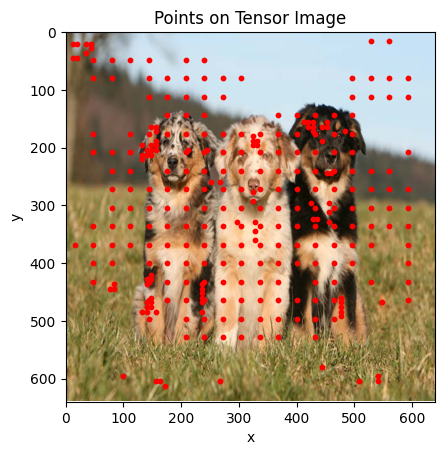

In [17]:
print(topk_ind.tolist()[0][:10])
for ind in topk_ind.tolist()[0][:10]:
    print(reverse_dict[ind], end='. ')
    
draw_points(input_tensor, topk_ind.tolist()[0][:300])

In [14]:
# print(len(feature_map))
# print(feature_map[0].shape)
# print(feature_map[1].shape)
# print(feature_map[2].shape)

In [15]:
# # 히트맵 생성
# temp_feat_0 = feature_map[0].detach().cpu().numpy()
# temp_feat_1 = feature_map[1].detach().cpu().numpy()
# temp_feat_2 = feature_map[2].detach().cpu().numpy()

# heatmap_0 = np.mean(temp_feat_0, axis=1).squeeze() # 채널 평균
# heatmap_0 = cv2.resize(heatmap_0, (image.width, image.height)) # 이미지 크기로 조정
# heatmap_0 = heatmap_0 / np.max(heatmap_0)

# heatmap = cv2.applyColorMap(np.uint8(255 * heatmap_0), cv2.COLORMAP_JET)
# overlayed_image = heatmap * 0.5 + np.array(image)
# overlayed_image = overlayed_image / np.max(overlayed_image)

# # 시각화
# plt.imshow(overlayed_image)
# plt.show()


# heatmap_1 = np.mean(temp_feat_1, axis=1).squeeze() # 채널 평균
# heatmap_1 = cv2.resize(heatmap_1, (image.width, image.height)) # 이미지 크기로 조정
# heatmap_1 = heatmap_1 / np.max(heatmap_1)

# heatmap = cv2.applyColorMap(np.uint8(255 * heatmap_1), cv2.COLORMAP_JET)
# overlayed_image = heatmap * 0.5 + np.array(image)
# overlayed_image = overlayed_image / np.max(overlayed_image)

# # 시각화
# plt.imshow(overlayed_image)
# plt.show()

# heatmap_2 = np.mean(temp_feat_2, axis=1).squeeze() # 채널 평균
# heatmap_2 = cv2.resize(heatmap_2, (image.width, image.height)) # 이미지 크기로 조정
# heatmap_2 = heatmap_2 / np.max(heatmap_2)
# # 원본 이미지에 히트맵 겹치기
# heatmap_2 = cv2.applyColorMap(np.uint8(255 * heatmap_2), cv2.COLORMAP_JET)
# overlayed_image = heatmap_2 * 0.5 + np.array(image)
# overlayed_image = overlayed_image / np.max(overlayed_image)
# # 시각화
# plt.imshow(overlayed_image)
# plt.show()

In [16]:
# import requests
# import torchvision
# from PIL import Image
# image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
# image = Image.open(requests.get(image_url, stream=True).raw)


# transform = torchvision.transforms.Compose([
#     torchvision.transforms.Resize((640,640)),
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# input_tensor = transform(image)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# input_tensor = input_tensor.to(device)
# # Add a batch dimension:
# input_tensor = input_tensor.unsqueeze(0)
# print(input_tensor.shape)

# # model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# # model.eval().to(device)

# # Run the model and display the detections
# boxes, scores, labels = predict(input_tensor, model, device, 0.5)
# image = draw_boxes(boxes, image)
# image
